In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsRegressor

from sklearn.model_selection import GridSearchCV
import gc  # Garbage Collector zur Speicherverwaltung
import sys
sys.path.append(os.path.abspath("../../"))
from eval_call import evaluate_model



df = pd.read_csv('../../data.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251079 entries, 0 to 251078
Data columns (total 15 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Unnamed: 0                251079 non-null  int64  
 1   brand                     251079 non-null  object 
 2   model                     251079 non-null  object 
 3   color                     250913 non-null  object 
 4   registration_date         251075 non-null  object 
 5   year                      251079 non-null  object 
 6   price_in_euro             251079 non-null  object 
 7   power_kw                  250945 non-null  object 
 8   power_ps                  250950 non-null  object 
 9   transmission_type         251079 non-null  object 
 10  fuel_type                 251079 non-null  object 
 11  fuel_consumption_l_100km  224206 non-null  object 
 12  fuel_consumption_g_km     251079 non-null  object 
 13  mileage_in_km             250927 non-null  f

In [3]:
import sys
import os

sys.path.append(os.path.abspath("../.."))
from Preprocessing.DropAll_preprocessing_pipeline import preprocessing_pipeline

df = preprocessing_pipeline(df)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 178095 entries, 0 to 222896
Data columns (total 10 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   brand                     178095 non-null  object 
 1   model                     178095 non-null  object 
 2   color                     178095 non-null  object 
 3   price_in_euro             178095 non-null  int64  
 4   power_ps                  178095 non-null  float64
 5   transmission_type         178095 non-null  object 
 6   fuel_type                 178095 non-null  object 
 7   fuel_consumption_l_100km  178095 non-null  float64
 8   mileage_in_km             178095 non-null  float64
 9   age                       178095 non-null  int64  
dtypes: float64(3), int64(2), object(5)
memory usage: 14.9+ MB


In [ ]:
from sklearn.model_selection import train_test_split

y = df['price_in_euro']
X = df.drop(['price_in_euro'], axis=1)

numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [6]:

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())  # Scaling is crucial for KNN
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# KNN pipeline with initial K=5 
knn_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', KNeighborsRegressor(n_neighbors=5))
])


final_knn_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', KNeighborsRegressor(
        n_neighbors=4,
        weights='distance',  
        algorithm='auto',
        n_jobs=-1  
    ))
])


print("\nTraining KNN model with optimal K...")
final_knn_pipeline.fit(X_train, y_train)

# Make predictions
y_pred_knn = final_knn_pipeline.predict(X_test)

# Evaluate model
evaluate_model(y_test, y_pred_knn, "KNN Regression")


# Clean up memory
gc.collect()





Training KNN model with optimal K...
KNN Regression Performance Metrics:
MAE: 3742.94
MSE: 191528123.06
RMSE: 13839.37
R²: 0.81
------------------------------


207

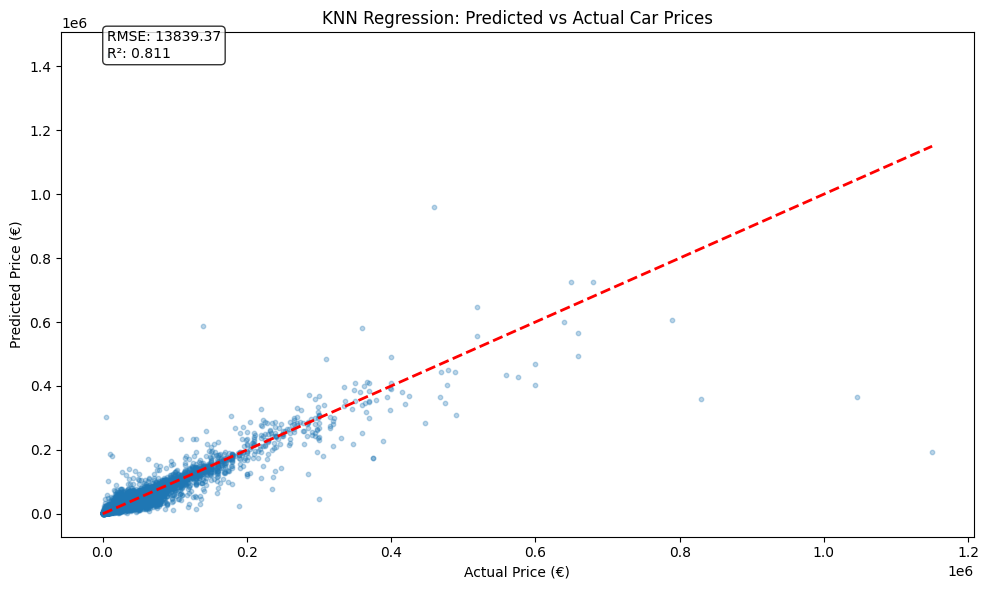

In [ ]:

# Plot Predicted vs. Actual Values
plt.figure(figsize=(6,4))
plt.scatter(y_test_inv, y_pred_inv, s=5)
plt.plot([min(y_test_inv), max(y_test_inv)], [min(y_test_inv), max(y_test_inv)], 'r--')  # Diagonal line
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs. Actual Values - Full Dataset')
plt.show()